In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# GLM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

from pathlib import Path
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Add parent directory to sys.path
sys.path.append(os.path.abspath('..'))

from data_handler import *
from data_transformation import *
from helper_functions import *

Load credentials to Access the database if needed

In [4]:
base_dir = 'C:\\Users\\RaymondGreenfield\\OneDrive - endurancedirect.com\\Documents\\Actuarial_Work'
creds_file = Path(base_dir) / 'Creds' / 'creds.json'

1) Load coverage dataframe from the DataHandler 

In [6]:
# Change the date in the function to get the data for the relevant month

onlevel_handler = OnlevelHandler(base_dir, creds_file)

#df = onlevel_handler.load_VMAX_onleveled_df('2024.10')
#print(df_vmax.head())

df = onlevel_handler.load_APEX_onleveled_df('2024.10')
#print(df_apex.head())

#df = onlevel_handler.load_XCARE_onleveled_df('2024.10')
#print(df_xcare.head())

Initialized azhelper with credentials
Loaded APEX data from C:\Users\RaymondGreenfield\OneDrive - endurancedirect.com\Documents\Actuarial_Work\Onlevel\202410\Onlevel.2024.10\DLR\APEX.2024.10.Onleveled.csv


In [14]:
df.head()

,Make,Model_Category1,Vehicle_Class,Dealer_State,Paid Trended by PaymentDate,Earned_Count,Pure_Premium,Vehicle_Class_Encoded
0,0,124,3,IL,628.1079,0.345226,1819.410466,0
1,0,124,3,NJ,5337.1229,1.000000,5337.122900,0
2,0,332,3,AL,0.0000,1.000000,0.000000,0
3,0,332,3,AZ,0.0000,0.716530,0.000000,0
4,0,332,3,CA,0.0000,7.690967,0.000000,0


2) Exploratory Data Analysis

In [7]:
print("Unique Coverage Group: \n",df["Coverage_Group"].unique() )
print("Unique Vehicle_Class: \n", df["Vehicle_Class"].unique())
print("The number of Vehicle Class: ", len(df["Vehicle_Class"].unique()))

Unique Coverage Group: 
 ['APEX' 'APEX/RE']
Unique Vehicle_Class: 
 [ 2  3  4  1  5  7  9  8  6 10]
10


In [15]:
# Summary Statistics
df.describe()

,Make,Model_Category1,Vehicle_Class,Paid Trended by PaymentDate,Earned_Count,Pure_Premium,Vehicle_Class_Encoded
count,17370.000000,17370.000000,17370.000000,1.737000e+04,17370.000000,16992.000000,17370.000000
mean,19.533218,348.617674,3.917904,9.480594e+03,9.662687,973.502631,3.580771
std,14.000879,187.906066,2.206989,4.617367e+04,33.487399,3869.611896,3.251905
min,0.000000,0.000000,1.000000,-1.201875e+02,0.000000,-43.612249,0.000000
25%,7.000000,192.000000,2.000000,0.000000e+00,1.000000,0.000000,1.000000
50%,16.000000,346.000000,3.000000,2.406774e+02,1.952005,109.775249,3.000000
75%,30.000000,518.750000,5.000000,5.313491e+03,5.922587,1017.630676,8.000000
max,50.000000,682.000000,10.000000,1.972626e+06,1157.686001,302541.515310,9.000000


In [17]:
df.columns

Index(['Make', 'Model_Category1', 'Vehicle_Class', 'Dealer_State',
       'Paid Trended by PaymentDate', 'Earned_Count', 'Pure_Premium',
       'Vehicle_Class_Encoded'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17370 entries, 0 to 17369
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Make                         17370 non-null  int32  
 1   Model_Category1              17370 non-null  int32  
 2   Vehicle_Class                17370 non-null  int64  
 3   Dealer_State                 17370 non-null  object 
 4   Paid Trended by PaymentDate  17370 non-null  float64
 5   Earned_Count                 17370 non-null  float64
 6   Pure_Premium                 16992 non-null  float64
 7   Vehicle_Class_Encoded        17370 non-null  int64  
dtypes: float64(3), int32(2), int64(2), object(1)
memory usage: 950.0+ KB


Helper Functions for EDA

In [1]:
def split_categorical_quantitative(df):
    """
    Splits the DataFrame into two DataFrames: one for categorical data, one for quantitative data.
    
    Args:
        df (pd.DataFrame): Input DataFrame
    
    Returns:
        categorical_df (pd.DataFrame): DataFrame with categorical columns
        quantitative_df (pd.DataFrame): DataFrame with quantitative (numerical) columns
    """
    # Categorical data: typically object, category, or boolean types
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

    # Quantitative data: typically integer or float types
    quantitative_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Create separate DataFrames for categorical and quantitative data
    categorical_df = df[categorical_cols]
    quantitative_df = df[quantitative_cols]
    
    return categorical_df, quantitative_df

def corr_matrix(df):
    """ Display the correlation matrix of the imported df. """
    
    # Split the DataFrame into categorical and quantitative parts
    categorical_df, quantitative_df = split_categorical_quantitative(df)
    
    corr_matrix = quantitative_df.corr()

    # df.corr(method='spearman')  # Spearman rank correlation
    # df.corr(method='kendall')   # Kendall Tau correlation

    # Display correlation matrix
    print(corr_matrix)

    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

def plot_3D(df):
    """ Add a 3-D plot to the clustering analysis """

    # Encode Vehicle_Class as numeric for colormap
    class_mapping = {cls: idx for idx, cls in enumerate(df['Vehicle_Class'].unique())}
    df['Vehicle_Class_Encoded'] = df['Vehicle_Class'].map(class_mapping)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    scatter = ax.scatter(
        df['Make'].astype('category').cat.codes,  # Convert categorical data to numeric
        df['Model_Category1'].astype('category').cat.codes,
        df['Pure_Premium'],
        c=df['Vehicle_Class_Encoded'],
        cmap='viridis',
        marker='o'
    )

    # Set labels
    ax.set_xlabel('Make')
    ax.set_ylabel('Model')
    ax.set_zlabel('Pure Premium')

    # Set title
    ax.set_title('3D Scatter Plot')

    # Add legend
    handles = []
    for cls, idx in class_mapping.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=cls,
                                markerfacecolor=plt.cm.viridis(idx / len(class_mapping)), markersize=8))
    ax.legend(handles=handles, title='Vehicle Class', loc='best')


    unique_categories = df['Vehicle_Class'].unique()
    viridis_palette = sns.color_palette("viridis", len(unique_categories))
    palette = dict(zip(unique_categories, viridis_palette))

    sns.pairplot(df, vars=['Make', 'Model_Category1', 'Pure_Premium'], hue='Vehicle_Class', palette=palette)

    plt.legend()
    plt.show()

3) Data Processing
    - Any pipeline function is from the data_transformation module
    - Any 'add' function is from the helper_functions modules 
        - The functions are for Actuarial calculations (Loss Ratio, Freq, Severity, Pure_Premium, etc)

In [9]:
# Data Transformation
pred_cols = ['Make', 'Model_Category1', 'Vehicle_Class', 'Dealer_State']

df = filter_claim_count(df, threshold=10)
df['Model_Category1'] = df['Model'].apply(map_model_category1)
df = label_encoder_pipeline(df)
df = add_agg_pure_premium(df, pred_cols)

Pure_Premium added to the aggregated


In [10]:
# Filter for FL state only
df_FL = df[df["Dealer_State"] == "FL"] 
df_not_FL = df[df["Dealer_State"] != "FL"]

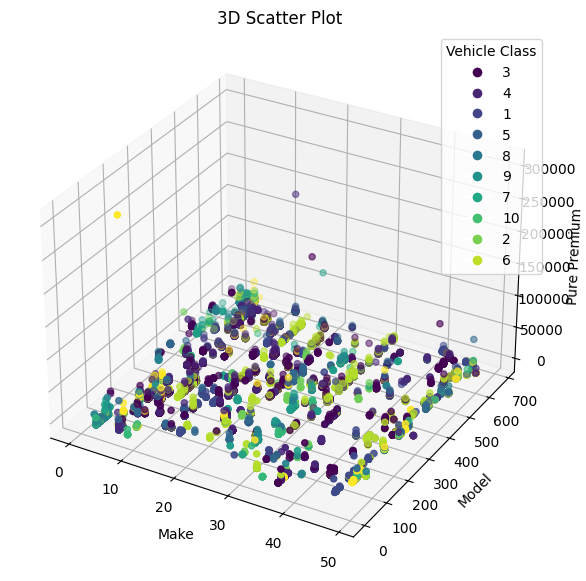

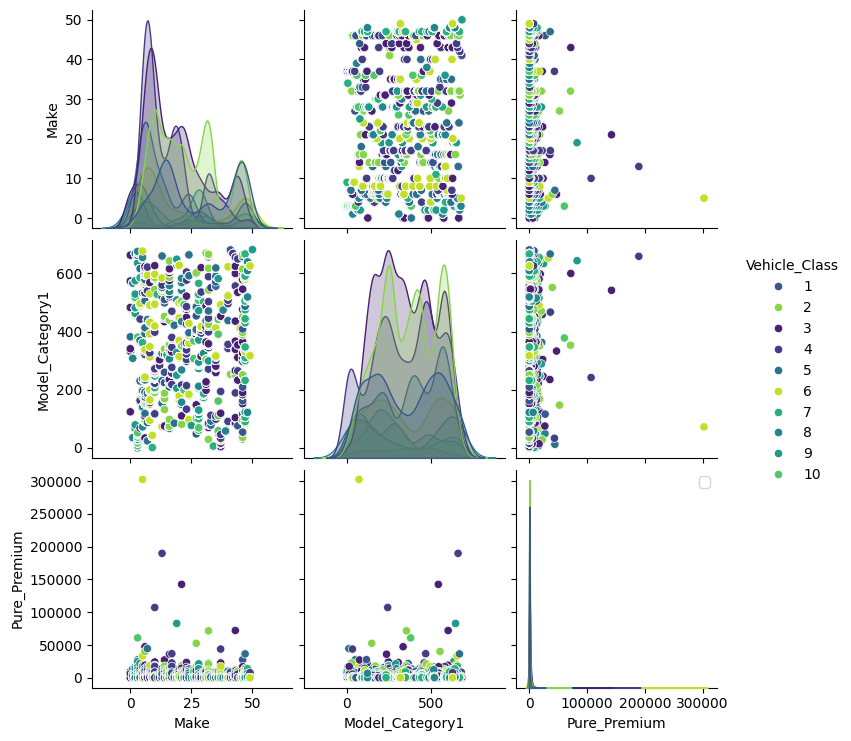

In [11]:
# Plot the Full Dataframe
plot_3D(df)

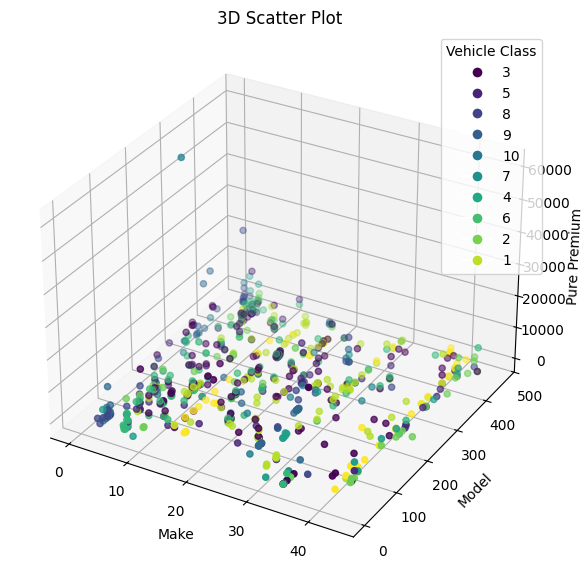

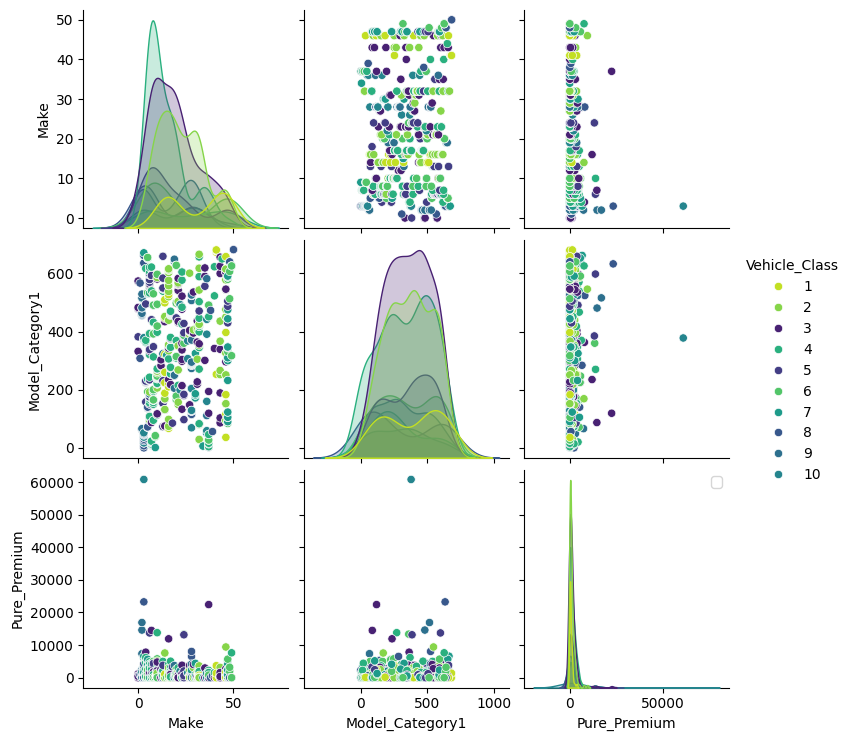

In [12]:
# Plot only the Florida Dataframe
plot_3D(df_FL)

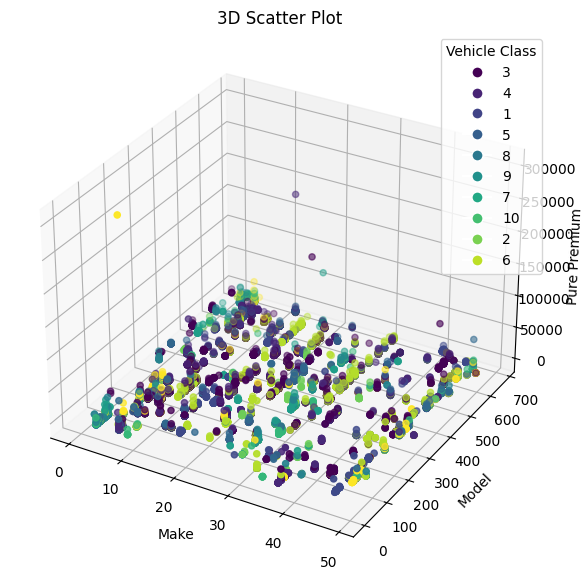

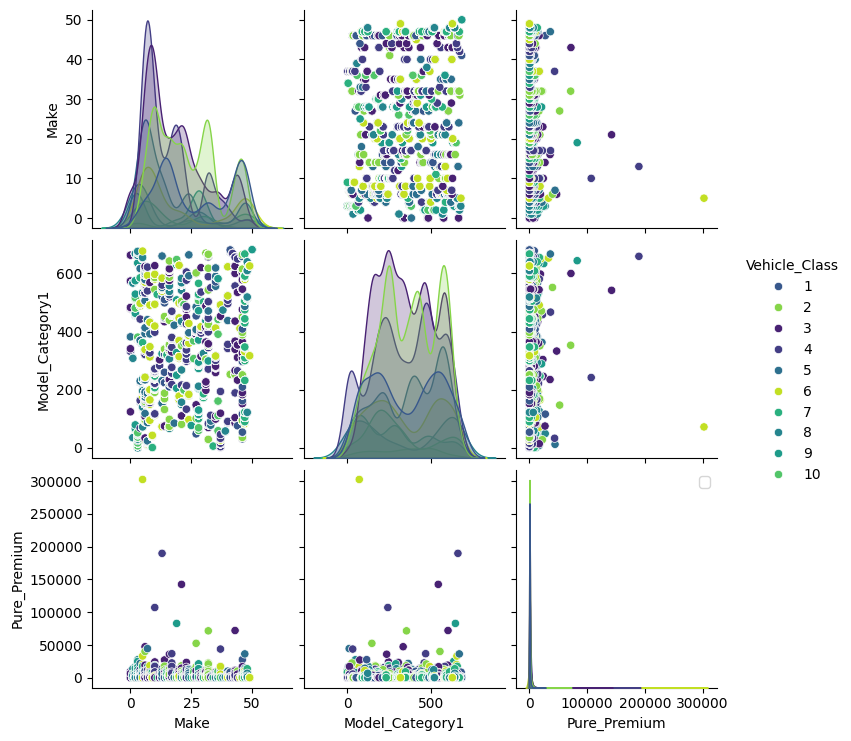

In [13]:
# Plot all but Florida Dataframe
plot_3D(df_not_FL)